# Зависимости

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import timm

import random


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim import lr_scheduler

import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.transforms import v2

## Будем подключать модули по мере необходимости

In [24]:
from mlops_lukianenko import dataset
from mlops_lukianenko import features

In [25]:
# Использование GPU по желанию

if torch.cuda.is_available():
  device = torch.device('cuda')
  print('Работаем на GPU')
else:
  device = torch.device('cpu')
  print('Работаем на CPU')


Работаем на GPU


In [26]:
data_dir = './dataset'

## Загрузка датасета из интернет

In [27]:
# create_folder_structure(data_dir)

In [28]:
# # Параметры
# classes = ["автомобиль", "мотоцикл", "автобус", "грузовик"]
# num_images_per_class = 150
# 
# # Скачиваем изображения
# for cls in classes:
#     train_folder = os.path.join(data_dir, 'train', cls)
#     dataset.download_images(cls, train_folder, num_images_per_class)



### чистим от битых файлов

In [29]:
features.clean_dataset(data_dir)

### готовим данные для дообучения

In [30]:
transform_pipeline = features.get_transforms_pipeline()

In [31]:
train_dataset, test_dataset = dataset.get_datasets(data_dir, transform_pipeline)

In [32]:
# Создаем DataLoader
train_loader, test_loader = features.get_loaders(train_dataset, test_dataset)

In [33]:
print("Данные разделены и подготовлены.")

Данные разделены и подготовлены.


## отобразим случайные данные из образованного датасета для проверки

In [34]:
from mlops_lukianenko import plots

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5877128].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.4482791].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.343704].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5877128].
Clipping

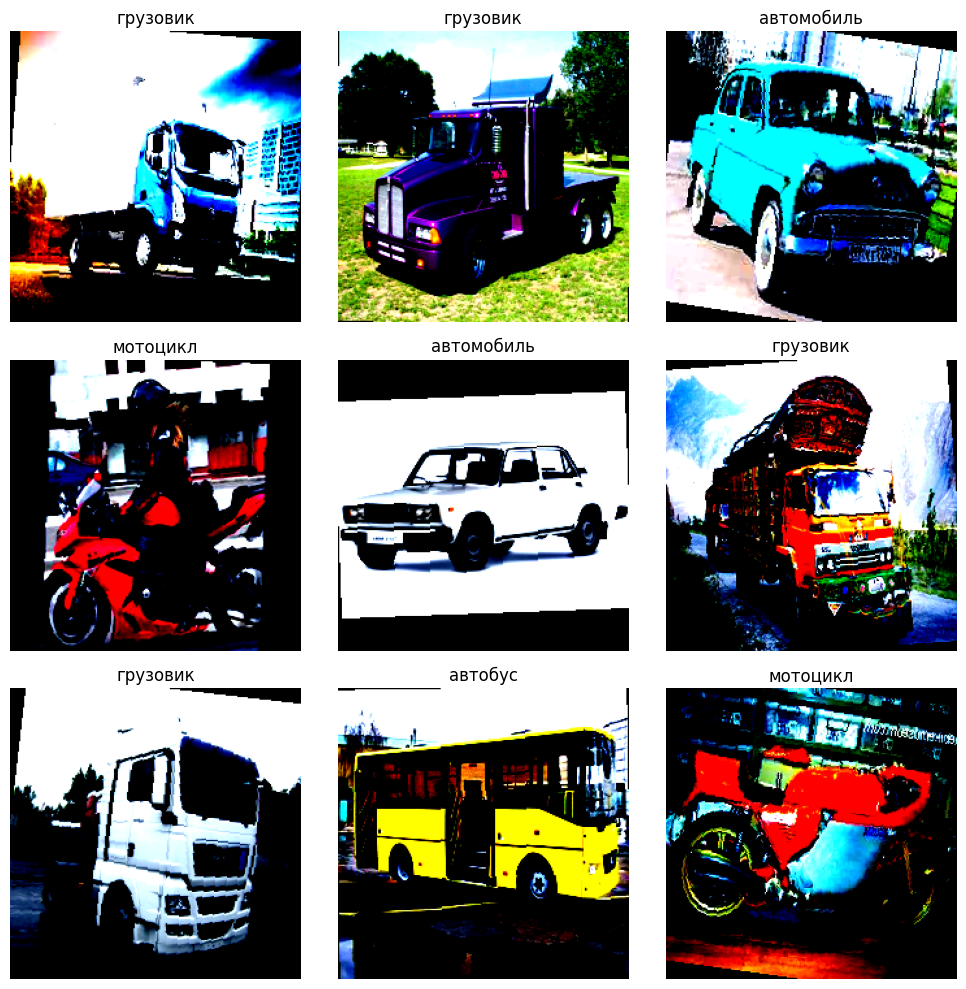

In [35]:
plots.show_random_classes(train_dataset,3)

In [36]:
model_name = "resnet50"  # Выбранная модель
pretrained_model = timm.create_model(model_name, pretrained=True)

In [37]:
from mlops_lukianenko.modeling import train

In [38]:

train.freeze_params(pretrained_model)

In [39]:
classes = ["автомобиль", "мотоцикл", "автобус", "грузовик"]
# Замена "головы" модели
num_classes = len(classes)  # Количество классов в задаче классификации
train.swap_head(pretrained_model, num_classes)


In [40]:
print("Модель подготовлена.")

Модель подготовлена.


In [41]:
# Подготовка для обучения
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(pretrained_model.parameters(), lr=0.001)

In [42]:
# Добавляем планировщик скорости обучения
scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)  # Каждые 3 эпохи lr уменьшается в 10 раз

### Начинаем дообучение
Сначала заморозим слои и заменим голову

In [43]:
pretrained_model = pretrained_model.to(device)
# Параметры обучени
num_epochs = 5

In [44]:
train.train_freezed(pretrained_model, num_epochs, train_loader, test_loader, device, loss_fn, optimizer, scheduler)

Freezed training Epoch 1/5


C:\workV\.Maga\3sem\RO\LAB5\MLOps\mlops\.venv\lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Freezed training Training loss: 1.1537938137849173
Test Accuracy: 71.19%
Freezed training Epoch 2/5
Freezed training Training loss: 0.7498897016048431
Test Accuracy: 78.81%
Freezed training Epoch 3/5
Freezed training Training loss: 0.5913177202145259
Test Accuracy: 77.97%
Freezed training Epoch 4/5
Freezed training Training loss: 0.4991978963216146
Test Accuracy: 80.51%
Freezed training Epoch 5/5
Freezed training Training loss: 0.5014408608277638
Test Accuracy: 79.66%


## размораживаем и дообучаем файн тюнингом

In [45]:
train.unfreeze(pretrained_model)

In [46]:
num_epochs=5
train.train_fine_tune(num_epochs, pretrained_model, train_loader, test_loader, device, loss_fn, optimizer, scheduler)

Fine-Tuning Epoch 1/5
Fine-Tuning Training loss: 0.48425356348355614
Test Accuracy: 83.90%
Fine-Tuning Epoch 2/5
Fine-Tuning Training loss: 0.38123922993739445
Test Accuracy: 83.05%
Fine-Tuning Epoch 3/5
Fine-Tuning Training loss: 0.35665523608525596
Test Accuracy: 84.75%
Fine-Tuning Epoch 4/5
Fine-Tuning Training loss: 0.3601360027988752
Test Accuracy: 79.66%
Fine-Tuning Epoch 5/5
Fine-Tuning Training loss: 0.3649691253900528
Test Accuracy: 84.75%


In [47]:
# plots.show_train_diagr()

In [48]:
from mlops_lukianenko.modeling import predict

3


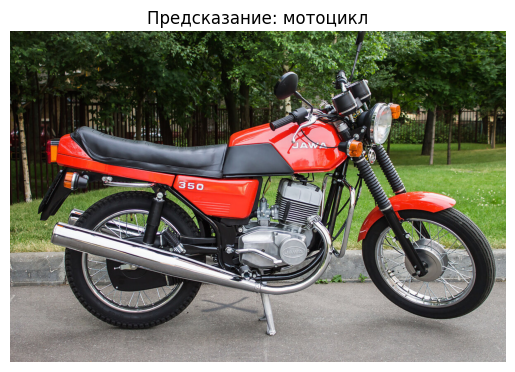

In [49]:

# Путь к случайному изображению
random_image_path = './scale_1200.jpg' # Укажите путь к изображению

predict.predict(random_image_path, device, pretrained_model, train_dataset)

## Экспорт в onnx и проверка что при обратном импорте модель работает

In [52]:
input = torch.randn(1, 3, 224, 224, device="cuda" if torch.cuda.is_available() else "cpu")
features.export_to_onnx(pretrained_model, input, "trained_model.onnx")

Модель экспортирована в ONNX: trained_model.onnx


In [59]:
import onnxruntime as ort

# Загрузка модели
onnx_model_path = "trained_model.onnx"
session = ort.InferenceSession(onnx_model_path)

input_name = session.get_inputs()[0].name
output_name = session.get_outputs()[0].name

# Предобработка изображения
def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0)
    return image.numpy()

# Тестовое изображение
image_path = random_image_path
input_data = preprocess_image(image_path)

# Инференс
predictions = session.run([output_name], {input_name: input_data})[0]
predicted_class = np.argmax(predictions, axis=1)[0]

# Классы
classes = ['автобус', 'автомобиль', 'грузовик', 'мотоцикл']
print(f"Предсказанный класс: {classes[predicted_class]}")

Предсказанный класс: мотоцикл
